In [1]:
!pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 11.2 MB/s eta 0:00:00
  Created wheel for databricks-cli: filename=databricks_cli-0.17.7-py3-none-any.whl size=143882 sha256=3d6909a2170560606915d8271daa22f92116bb7c4bba4347ff0b7946abfb15d8
  Stored in directory: /root/.cache/pip/wheels/ae/63/93/5402c1a09c1868a59d0b05013484e07af97a9d7b3dbd5bd39a
Successfully built databricks-cli


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow import keras
import mlflow

import pandas as pd
from plotly import express as px
from plotly import graph_objects as go

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv1D, Conv2D, Conv3D, MaxPool2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential

from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
tf.__version__# Set your variables for your environment


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

'2.12.0'

In [3]:
import os
import glob
import pandas as pd

In [4]:
df = pd.read_csv("/kaggle/input/butterfly-images40-species/butterflies and moths.csv")
df.head()

,class id,filepaths,labels,data set
0,0,train/ADONIS/001.jpg,ADONIS,train
1,0,train/ADONIS/002.jpg,ADONIS,train
2,0,train/ADONIS/003.jpg,ADONIS,train
3,0,train/ADONIS/004.jpg,ADONIS,train
4,0,train/ADONIS/005.jpg,ADONIS,train


In [5]:
# df = df.iloc[:3000,:]

In [6]:
width , height = (299, 299)
n_classes = df['labels'].nunique()
print(n_classes)
df.columns

100


Index(['class id', 'filepaths', 'labels', 'data set'], dtype='object')

In [7]:
#preprocessing data :
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(#rotation_range=90,
                                                                brightness_range=(0.5,1),
                                                                #shear_range=0.2,
                                                                #zoom_range=0.2,
                                                                channel_shift_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                rescale=1./255,
                                                                validation_split=0.3)


img_generator_flow_train = img_generator.flow_from_dataframe(
    dataframe=df, # the dataframe containing the filename and label column
    directory="/kaggle/input/butterfly-images40-species", # the directory containing the image files
    x_col="filepaths", # the name of the column with the filenames
    y_col="labels", # the name of the column with the labels
    target_size=(width, height),
    class_mode = "categorical", 
    batch_size=32, 
    subset="training")

img_generator_flow_valid = img_generator.flow_from_dataframe(
    dataframe=df, # the dataframe containing the filename and label column
    directory="/kaggle/input/butterfly-images40-species", # the directory containing the image files
    x_col="filepaths", # the name of the column with the filenames
    y_col="labels", # the name of the column with the labels
    target_size=(width, height),
    class_mode = "categorical", 
    batch_size=32, 
    subset="validation")

Found 9516 validated image filenames belonging to 100 classes.
Found 4078 validated image filenames belonging to 100 classes.


In [8]:
# Set your variables for your environment
EXPERIMENT_NAME="papillons-elo"

# Set tracking URI to your Heroku application
# mlflow.set_tracking_uri(os.environ["APP_URI"])
mlflow.set_tracking_uri("https://insects-mlflow.herokuapp.com/")


# Set experiment's info 
mlflow.set_experiment(EXPERIMENT_NAME)



# Get our experiment info
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

In [9]:
# Call mlflow autolog
mlflow.tensorflow.autolog()

mlflow.end_run()

with mlflow.start_run(experiment_id = experiment.experiment_id):
   
    mlflow.set_tag("user", "elo")
    mlflow.set_tag("model", "inceptionv3")
    mlflow.set_tag("description", "24cat")
    
    base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=(width, height,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )
    base_model.trainable = True

    fine_tune_at = len(base_model.layers) - 0.1*len(base_model.layers)

    for layer in base_model.layers[:int(fine_tune_at)]:
        layer.trainable = False
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalMaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(n_classes, activation="softmax")
    ])
    model.summary()

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                  loss = tf.keras.losses.CategoricalCrossentropy(),
                  metrics = [tf.keras.metrics.CategoricalAccuracy()])
    model.fit(img_generator_flow_train, validation_data=img_generator_flow_valid, epochs=10)

87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                                 
Total params: 22,007,684
Trainable params: 6,278,436
Non-trainable params: 15,729,248
_________________________________________________________________


2023/06/16 09:18:40 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.preprocessing.image.DataFrameIterator'>. Dataset logging skipped.
2023/06/16 09:18:40 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.preprocessing.image.DataFrameIterator'>. Dataset logging skipped.


Epoch 1/10
298/298 [==============================] - 201s 616ms/step - loss: 1.4728 - categorical_accuracy: 0.6987 - val_loss: 5.3166 - val_categorical_accuracy: 0.2285
Epoch 2/10
298/298 [==============================] - 131s 439ms/step - loss: 0.4660 - categorical_accuracy: 0.8799 - val_loss: 3.3603 - val_categorical_accuracy: 0.3762
Epoch 3/10
298/298 [==============================] - 132s 444ms/step - loss: 0.2691 - categorical_accuracy: 0.9231 - val_loss: 3.1417 - val_categorical_accuracy: 0.4451
Epoch 4/10
298/298 [==============================] - 129s 434ms/step - loss: 0.2233 - categorical_accuracy: 0.9362 - val_loss: 3.5209 - val_categorical_accuracy: 0.4407
Epoch 5/10
298/298 [==============================] - 129s 432ms/step - loss: 0.1714 - categorical_accuracy: 0.9513 - val_loss: 3.6577 - val_categorical_accuracy: 0.4586
Epoch 6/10
298/298 [==============================] - 129s 432ms/step - loss: 0.1619 - categorical_accuracy: 0.9526 - val_loss: 3.2501 - val_categoric

2023/06/16 09:42:34 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2023/06/16 09:42:34 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2023/06/16 09:43:45 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpne01s9sh/model, flavor: tensorflow), fall back to return ['tensorflow==2.12.0']. Set logging level to DEBUG to see the full traceback.


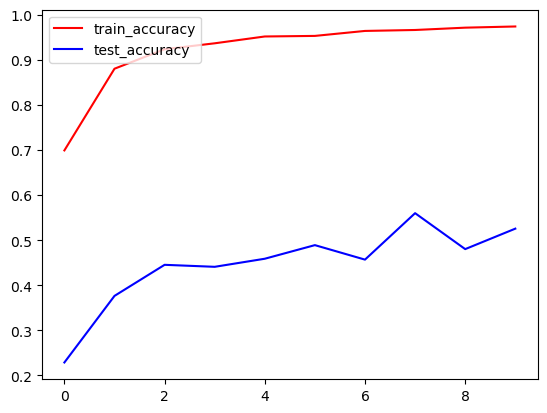

In [10]:
# Visualise train / Valid Accuracy
plt.plot(model.history.history["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(model.history.history["val_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()



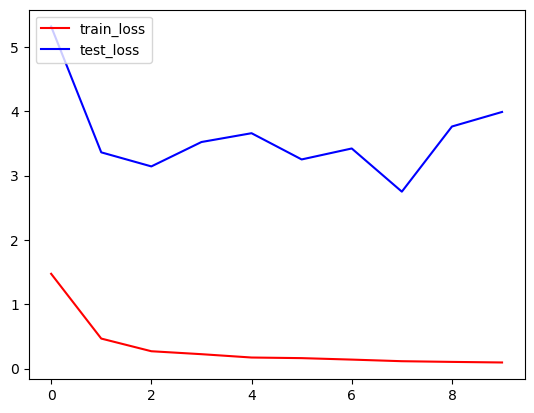

In [11]:
# Visualise train / Valid Loss
plt.plot(model.history.history["loss"], c="r", label="train_loss")
plt.plot(model.history.history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()
